# Coming from TensorFlow to NengoDL

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/from-tensorflow.ipynb)

NengoDL combines two frameworks: Nengo and TensorFlow.  This tutorial is designed for
people who are familiar with TensorFlow and looking to learn more about neuromorphic
modelling with NengoDL.  For the other approach, users familiar with Nengo looking to
learn how to use NengoDL, check out [this
tutorial](https://www.nengo.ai/nengo-dl/examples/from-nengo.html).

If you are familiar with Keras you may also be interested in
[KerasSpiking](https://www.nengo.ai/keras-spiking/), a companion project to NengoDL
that has a more minimal feature set, but integrates even more transparently with the
Keras API. See [this page](https://www.nengo.ai/keras-spiking/nengo-dl-comparison.html)
for a more detailed comparison between the two projects.

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot
import numpy as np
import tensorflow as tf

import nengo_dl


warnings.simplefilter("ignore")
tf.get_logger().addFilter(lambda rec: "Tracing is expensive" not in rec.msg)

## What is Nengo

We'll start with the very basics, where you might be wondering what Nengo is and why you
would want to use it.  Nengo is a tool for constructing and simulating neural networks.
That is, to some extent, the same purpose as TensorFlow (and its higher level API,
Keras).  For example, here is how we might build a simple two layer auto-encoder network
in TensorFlow:

In [2]:
n_in = 784
n_hidden = 64
minibatch_size = 50

# input
tf_a = tf.keras.Input(shape=(n_in,))

# first layer
tf_b = tf.keras.layers.Dense(
    n_hidden, activation=tf.nn.relu, kernel_initializer=tf.initializers.glorot_uniform()
)(tf_a)

# second layer
tf_c = tf.keras.layers.Dense(
    n_in, activation=tf.nn.relu, kernel_initializer=tf.initializers.glorot_uniform()
)(tf_b)

And here is how we would build the same network architecture in Nengo:

In [3]:
with nengo.Network() as auto_net:
    # input
    nengo_a = nengo.Node(np.zeros(n_in))

    # first layer
    nengo_b = nengo.Ensemble(n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    nengo_c = nengo.Ensemble(n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, transform=nengo_dl.dists.Glorot()
    )

    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

One difference you'll note is that with Nengo we separate the creation of the layers and
the creation of the connections between layers.  This is because the connection
structure in Nengo networks often has a lot more state and general complexity than in
typical deep learning networks, so it is helpful to be able to control it independently
(we'll see examples of this later).

Another new object you may notice is the `nengo.Probe`.  This is used to collect data
from the simulation; by adding a probe to `nengo_c.neurons`, we are indicating that we
want to collect the activities of those neurons when the simulation is running.  You can
think of this like the `outputs` arguments in a Keras Model.

We will not go into a lot of detail on Nengo here; there is much more functionality
available, but we will focus on the features most familiar or relevant to those coming
from a TensorFlow background.  For a more in-depth introduction to Nengo, check out the
Nengo-specific [documentation](https://www.nengo.ai/nengo/) and
[examples](https://www.nengo.ai/nengo/examples.html).

## Simulating a network

To simulate a Keras network we create a `Model` and call `model.predict`:

In [4]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
out = model.predict(np.ones((minibatch_size, n_in)))
print(out.shape)

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 2ms/step


(50, 784)


Again, accomplishing the same thing in Nengo bears many similarities.  We create a
`Simulator` and call `sim.predict`:

In [5]:
with nengo_dl.Simulator(network=auto_net, minibatch_size=minibatch_size) as sim:
    out = sim.predict(np.ones((minibatch_size, 1, n_in)))
    print(out[p_c].shape)

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (30%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 280ms/step


(50, 1, 784)


One difference you may note is the extra dimension with size 1 in the shape of the Nengo
inputs and outputs.  This represents the time dimension; in this example we're only
running for a
single timestep, which is why it has size 1, but this could be used to provide different
input values on each simulation timestep.

This highlights a key difference between Nengo and TensorFlow.  Nengo simulations are
fundamentally temporal in nature; unlike TensorFlow where the graph simply represents an
abstract set of computations, in Nengo we (almost) always think of the graph as
representing a stateful neural simulation, where values are accumulated, updated, and
communicated over time.  This is not to say there is no overlap (we can create
TensorFlow simulations that execute over time, and we can create Nengo simulations
without temporal dynamics), but this is a different way of thinking about computations
that influences how we construct and simulate networks in Nengo.

More details on the NengoDL Simulator can be found in [the user
guide](https://www.nengo.ai/nengo-dl/simulator.html).

## Spiking networks

Although Nengo can be used to create TensorFlow-style networks, it has been primarily
designed for a different style of modelling: "neuromorphic" networks.  Neuromorphic
networks include features drawn from biological neural networks, in an effort to
understand or recreate the functionality of biological brains.  Note that these models
fall on a spectrum with standard artificial neural networks, with different approaches
incorporating different biological features.  But in general the structure and
parameterization of these networks often differs significantly from standard deep
network architectures.

We touched on this above in the discussion of temporality, which is one common feature
of neuromorphic networks.  Another common characteristic is the use of more complicated
neuron models, in particular spiking neurons.  In contrast to "rate" neurons (like
`relu`) that output a continuous value, spiking neurons communicate via discrete bursts
of output called spikes.

We can visualize this difference with a simple 1-layer network. In this example we'll
use `sim.run_steps` to run the simulation, rather than `sim.predict`.  `sim.run_steps`
(or `sim.run`) is a standard Nengo Simulator execution function (as opposed to
`sim.predict`, which is specific to NengoDL).  We could use either one, but you will
probably see `sim.run` in Nengo code, so we introduce it here.  The main difference in
this case is that results will be stored in the `sim.data` dictionary, as opposed to
being returned directly from `sim.predict`.

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (50%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (50%)             | ETA: 0:00:00

| #                           Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

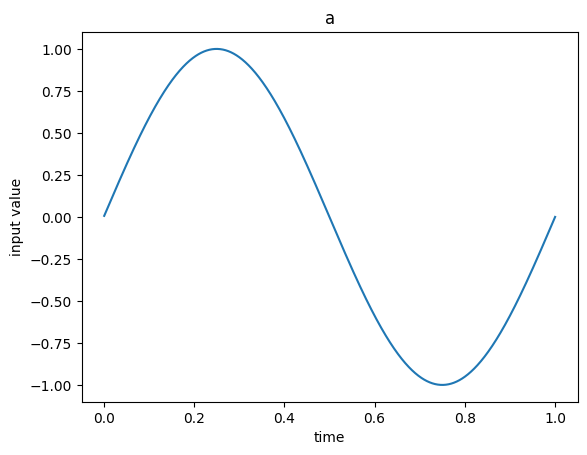

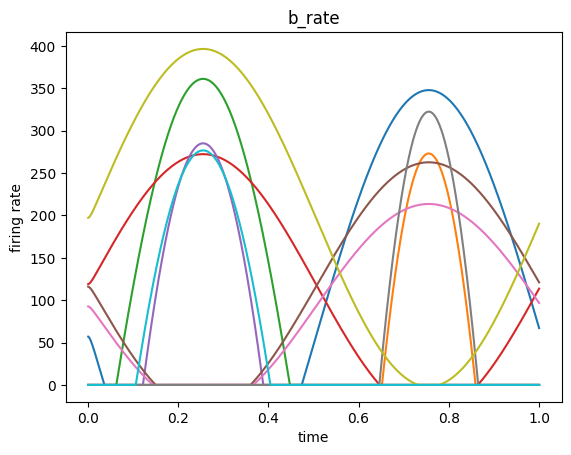

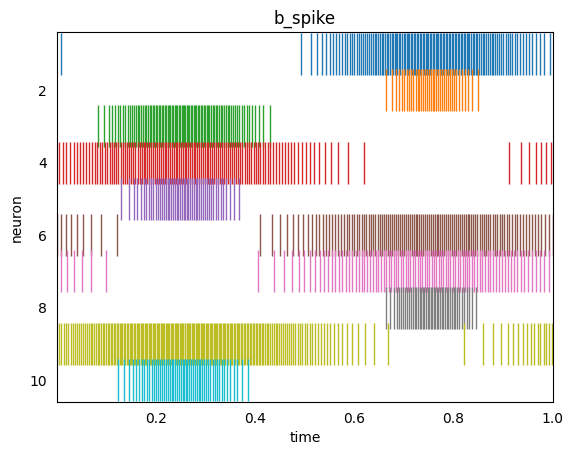

In [6]:
with nengo.Network() as net:
    # our input node will output a sine wave with a period of 1 second
    a = nengo.Node(lambda t: np.sin(2 * np.pi * t))

    # we'll create one ensemble with rate neurons
    b_rate = nengo.Ensemble(10, 1, neuron_type=nengo.RectifiedLinear(), seed=2)
    nengo.Connection(a, b_rate)

    # and another ensemble with spiking neurons
    b_spike = nengo.Ensemble(10, 1, neuron_type=nengo.SpikingRectifiedLinear(), seed=2)
    nengo.Connection(a, b_spike)

    p_a = nengo.Probe(a)
    p_rate = nengo.Probe(b_rate.neurons)
    p_spike = nengo.Probe(b_spike.neurons)

with nengo_dl.Simulator(net) as sim:
    # simulate the model for 1 second
    # note that we are not providing any input data, so input
    # data will be automatically generated based on the sine function
    # in the Node definition.
    sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[p_a])
plt.xlabel("time")
plt.ylabel("input value")
plt.title("a")

plt.figure()
plt.plot(sim.trange(), sim.data[p_rate])
plt.xlabel("time")
plt.ylabel("firing rate")
plt.title("b_rate")

plt.figure()
rasterplot(sim.trange(), sim.data[p_spike])
plt.xlabel("time")
plt.ylabel("neuron")
plt.title("b_spike")
plt.show()

Each neuron responds to the input signal differently due to the random parameterization
in the network (e.g. connection weights and biases).  We have matched the
parameterization in the rate and spiking ensembles so that it is easier to see the
parallels.

Note that the same information is being represented in the two ensembles.  For example,
when the second neuron (orange) is outputting a high continuous value (in the second
graph), the corresponding spiking neuron is outputting more discrete spikes (orange
lines in the third graph).

We can see the parallels more clearly if we introduce another Nengo feature, synaptic
filters.  This is inspired by a biological feature where discrete spikes induce a
continuous electrical waveform in the receiving neuron, at the synapse (the point where
the two neurons connect).  But computationally we can think of this simply as applying a
filter to the spiking signal.

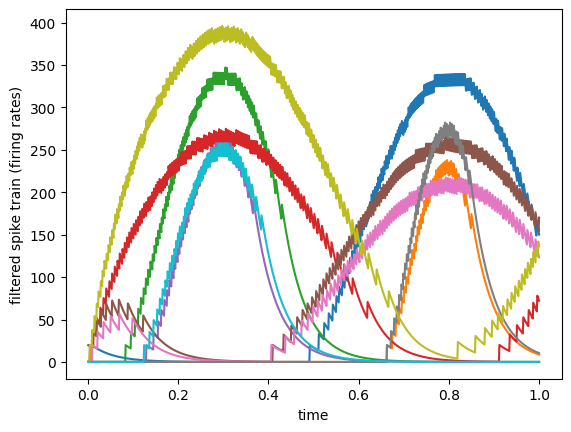

In [7]:
# nengo uses a linear lowpass filter by default
filt = nengo.Lowpass(tau=0.05)

# apply filter to ensemble output spikes
filtered_spikes = filt.filt(sim.data[p_spike])

plt.figure()
plt.plot(sim.trange(), filtered_spikes)
plt.xlabel("time")
plt.ylabel("filtered spike train (firing rates)")
plt.show()

We can see how the spike trains, when viewed through a synaptic filter, approximate the
continuous rate values in the second graph above.

In this example we have computed the filtered signal manually for demonstration
purposes, but in a typical Nengo model these synaptic filters are applied throughout the
model, on the `Connection` objects.  For example, the above filtering would be
equivalent to `nengo.Connection(b_spike.neurons, x, synapse=0.05)` (from the perspective
of a hypothetical downstream object `x`).

This is a helpful duality to keep in mind when coming to neuromorphic modelling and
Nengo from a standard deep network background.  Although spiking neurons seem like a
radically different paradigm, they can compute and communicate the same information as
their rate counterparts.  But note that this only makes sense when we think of the
network temporally (neurons spiking and being filtered over time).

There are many other neuron types built into Nengo (see [the
documentation](https://www.nengo.ai/nengo/frontend-api.html#neuron-types) for a complete
list).  These neuron models have various different behaviours, and managing their
parameterization and simulation is an important part of Nengo's design.

## Inserting TensorFlow code

The goal of NengoDL is not to replace TensorFlow or Nengo, but to allow them to smoothly
work together.  Thus one important feature is the ability to write TensorFlow code
directly, and insert it into a Nengo network.  This allows us to use whichever framework
is best suited for different parts of a model.

This functionality is accessed through the `nengo_dl.TensorNode` class.  This allows us
to wrap TensorFlow code in a Nengo object, so that it can easily communicate with the
rest of a Nengo model.  The TensorFlow code is written in a function that takes
`tf.Tensors` as input, applies the desired manipulations through TensorFlow operations,
and returns a `tf.Tensor`.  We then pass that function to the TensorNode.

For simple cases we can use `nengo_dl.Layer`.  This is a simplified interface for
constructing `TensorNodes` that mimics the Keras functional API.  For example, suppose
we want to apply batch normalization to the output of one of the Nengo ensembles.  There
is no built-in way to do batch normalization in Nengo, so we can instead turn to
TensorFlow for this part of the model.

In [8]:
with net:
    batch_norm = nengo_dl.Layer(tf.keras.layers.BatchNormalization(momentum=0.9))(
        b_rate.neurons
    )
    p_batch_norm = nengo.Probe(batch_norm)

This is essentially equivalent to the Keras layer `tf.keras.layers.BatchNormalization`,
except it works with Nengo objects.  For example, `b_rate` is a `nengo.Ensemble` in this
case, and we can add Probes or Connections to `batch_norm` in the same way as any other
Nengo object.

Using `nengo_dl.Layer` is simply a shortcut for creating a `TensorNode` and
`Connection`; the above is equivalent to

In [9]:
with net:
    batch_norm = nengo_dl.TensorNode(
        tf.keras.layers.BatchNormalization(momentum=0.9),
        shape_in=(10,),
        pass_time=False,
    )
    nengo.Connection(b_rate.neurons, batch_norm, synapse=None)
    p_batch_norm = nengo.Probe(batch_norm)

In general, we can use any function (a built in TensorFlow function or one we write
ourselves) in a TensorNode.  It can accept two parameters, `t` and `x`, where `t` is the
current simulation time and `x` is the value of any Connections incoming to the
TensorNode.  We can use `pass_time=False` if we don't need the time input. `x` will have
shape `(minibatch_size,) + shape_in`, where `shape_in` is the parameter passed to the
`TensorNode` (or inferred from the input object in the case of `nengo_dl.Layer`).  The
`TensorNode`/`Layer` function should return a `tf.Tensor` with shape `(minibatch_size,)
+ shape_out`, where `shape_out` is the output dimensionality of the node (dependent on
the manipulations applied to the inputs `x`).  We could explicitly specify
`shape_out=(10,)` in the above example, or if we don't specify the output shape it will
be determined automatically by calling the node function with placeholder inputs.

Here is a simple network to illustrate a TensorNode's input and output:

In [10]:
with nengo.Network() as net:
    # node to provide an input value for the TensorNode
    a = nengo.Node([0.5, -0.1])

    # a TensorNode function to illustrate i/o
    def tensor_func(t, x):
        # print out the value of inputs t and x
        print_t = tf.print("t:", t)
        with tf.control_dependencies([print_t]):
            print_x = tf.print("x:", x)

        # output t + x
        with tf.control_dependencies([print_x]):
            return tf.add(t, x)

    # create the TensorNode
    b = nengo_dl.TensorNode(tensor_func, shape_in=(2,), shape_out=(2,))
    nengo.Connection(a, b, synapse=None)

    p = nengo.Probe(b)

with nengo_dl.Simulator(net) as sim:
    print("TensorNode input:")
    data = sim.predict(n_steps=10)
    print("TensorNode output:")
    print(data[p])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

TensorNode input:
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

t: 0.001


x: [[0.5 -0.1]]


t: 0.002


x: [[0.5 -0.1]]


t: 0.003


x: [[0.5 -0.1]]


t: 0.004


x: [[0.5 -0.1]]


t: 0.00500000035


x: [[0.5 -0.1]]


t: 0.006


x: [[0.5 -0.1]]


t: 0.007


x: [[0.5 -0.1]]


t: 0.008


x: [[0.5 -0.1]]


t: 0.00900000054


x: [[0.5 -0.1]]


t: 0.0100000007


x: [[0.5 -0.1]]


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 157ms/step


TensorNode output:
[[[ 0.501 -0.099]
  [ 0.502 -0.098]
  [ 0.503 -0.097]
  [ 0.504 -0.096]
  [ 0.505 -0.095]
  [ 0.506 -0.094]
  [ 0.507 -0.093]
  [ 0.508 -0.092]
  [ 0.509 -0.091]
  [ 0.51  -0.09 ]]]


We can see, as we expect, that the input tensor `t` is reflecting the current simulation
time over the 10 timesteps we executed, and `x` contains the value of the input Node
that we connected to the TensorNode.  And we can see in the probe data that the
TensorNode is outputting the operation we defined in TensorFlow (`tf.add(t, x)`).

We can define more complicated TensorNodes by implementing a custom Keras Layer.  This
can be useful, for example, if the TensorNode requires internal parameters (which should
be created in the Keras Layer's `build` function).

Here is a simple TensorNode that illustrates the usage of a custom Layer:

In [11]:
with nengo.Network() as net:

    class MyLayer(tf.keras.layers.Layer):
        def build(self, input_shape):
            self.w = self.add_weight(shape=(1, 1))

        def call(self, inputs):
            return inputs * self.w

    a = nengo_dl.TensorNode(MyLayer(), shape_in=(1,), pass_time=False)

More details on TensorNode usage can be found in [the user
guide](https://www.nengo.ai/nengo-dl/tensor-node.html).

## Deep learning parameter optimization

NengoDL allows model parameters to be optimized via TensorFlow optimization algorithms,
through the `Simulator.fit` function.  Returning to the autoencoder examples from the
beginning of this tutorial, we'll optimize those networks to encode MNIST digits.

In [12]:
# download MNIST dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
# flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))

n_epochs = 2

In TensorFlow the training would be done something like:

Epoch 1/2


   1/1875 [..............................] - ETA: 10:05 - loss: 8326.1504

  30/1875 [..............................] - ETA: 3s - loss: 4352.9399   

  60/1875 [..............................] - ETA: 3s - loss: 3685.5342

  90/1875 [>.............................] - ETA: 3s - loss: 3284.2490

 120/1875 [>.............................] - ETA: 2s - loss: 3013.5022

 150/1875 [=>............................] - ETA: 2s - loss: 2819.6089

 180/1875 [=>............................] - ETA: 2s - loss: 2657.9858

 210/1875 [==>...........................] - ETA: 2s - loss: 2518.7446

 239/1875 [==>...........................] - ETA: 2s - loss: 2409.3962

 269/1875 [===>..........................] - ETA: 2s - loss: 2313.4900

 299/1875 [===>..........................] - ETA: 2s - loss: 2231.4326

 328/1875 [====>.........................] - ETA: 2s - loss: 2162.0017

 358/1875 [====>.........................] - ETA: 2s - loss: 2098.3999

 388/1875 [=====>........................] - ETA: 2s - loss: 2041.3777

 417/1875 [=====>........................] - ETA: 2s - loss: 1994.8074

 447/1875 [======>.......................] - ETA: 2s - loss: 1948.6331

 477/1875 [======>.......................] - ETA: 2s - loss: 1905.0234

 504/1875 [=======>......................] - ETA: 2s - loss: 1870.6309

 533/1875 [=======>......................] - ETA: 2s - loss: 1836.1836

 563/1875 [========>.....................] - ETA: 2s - loss: 1804.9769

 593/1875 [========>.....................] - ETA: 2s - loss: 1773.9113

 623/1875 [========>.....................] - ETA: 2s - loss: 1745.7571

 653/1875 [=========>....................] - ETA: 2s - loss: 1718.0511

 681/1875 [=========>....................] - ETA: 2s - loss: 1695.8390

 711/1875 [==========>...................] - ETA: 2s - loss: 1672.3909

 741/1875 [==========>...................] - ETA: 1s - loss: 1651.6156

 768/1875 [===========>..................] - ETA: 1s - loss: 1632.1095

 798/1875 [===========>..................] - ETA: 1s - loss: 1612.7838

 828/1875 [============>.................] - ETA: 1s - loss: 1594.5753

 858/1875 [============>.................] - ETA: 1s - loss: 1578.1429

 888/1875 [=============>................] - ETA: 1s - loss: 1563.2603

 918/1875 [=============>................] - ETA: 1s - loss: 1547.9739

 948/1875 [==============>...............] - ETA: 1s - loss: 1532.8357

 978/1875 [==============>...............] - ETA: 1s - loss: 1518.3298

1008/1875 [===============>..............] - ETA: 1s - loss: 1505.1489

1039/1875 [===============>..............] - ETA: 1s - loss: 1492.4709

1065/1875 [================>.............] - ETA: 1s - loss: 1481.5981

1095/1875 [================>.............] - ETA: 1s - loss: 1470.1594

1125/1875 [=================>............] - ETA: 1s - loss: 1458.2448

1155/1875 [=================>............] - ETA: 1s - loss: 1447.9316

1185/1875 [=================>............] - ETA: 1s - loss: 1437.3759

1215/1875 [==================>...........] - ETA: 1s - loss: 1427.1858

1245/1875 [==================>...........] - ETA: 1s - loss: 1417.4050

1275/1875 [===================>..........] - ETA: 1s - loss: 1408.3523

1305/1875 [===================>..........] - ETA: 0s - loss: 1399.4020

1335/1875 [====================>.........] - ETA: 0s - loss: 1389.9316

1365/1875 [====================>.........] - ETA: 0s - loss: 1381.2455

1395/1875 [=====================>........] - ETA: 0s - loss: 1373.4362

1425/1875 [=====================>........] - ETA: 0s - loss: 1365.5173

1455/1875 [======================>.......] - ETA: 0s - loss: 1358.2520

1485/1875 [======================>.......] - ETA: 0s - loss: 1351.4069

1515/1875 [=======================>......] - ETA: 0s - loss: 1344.7242

1545/1875 [=======================>......] - ETA: 0s - loss: 1337.9066

1575/1875 [========================>.....] - ETA: 0s - loss: 1330.9513

1605/1875 [========================>.....] - ETA: 0s - loss: 1324.4965

1635/1875 [=========================>....] - ETA: 0s - loss: 1318.8816

1665/1875 [=========================>....] - ETA: 0s - loss: 1312.6918

1694/1875 [==========================>...] - ETA: 0s - loss: 1306.4990

1724/1875 [==========================>...] - ETA: 0s - loss: 1300.8717

1754/1875 [===========================>..] - ETA: 0s - loss: 1294.9215

1783/1875 [===========================>..] - ETA: 0s - loss: 1289.6688

1811/1875 [===========================>..] - ETA: 0s - loss: 1284.9987

1841/1875 [============================>.] - ETA: 0s - loss: 1279.5668

1870/1875 [============================>.] - ETA: 0s - loss: 1274.9279

1875/1875 [==============================] - 4s 2ms/step - loss: 1273.8501


Epoch 2/2


   1/1875 [..............................] - ETA: 4s - loss: 1036.4424

  31/1875 [..............................] - ETA: 3s - loss: 949.6783 

  60/1875 [..............................] - ETA: 3s - loss: 949.5775

  90/1875 [>.............................] - ETA: 3s - loss: 952.7581

 120/1875 [>.............................] - ETA: 3s - loss: 949.7206

 150/1875 [=>............................] - ETA: 2s - loss: 953.7512

 180/1875 [=>............................] - ETA: 2s - loss: 950.3074

 210/1875 [==>...........................] - ETA: 2s - loss: 955.8133

 240/1875 [==>...........................] - ETA: 2s - loss: 951.4022

 270/1875 [===>..........................] - ETA: 2s - loss: 950.3480

 300/1875 [===>..........................] - ETA: 2s - loss: 948.4807

 329/1875 [====>.........................] - ETA: 2s - loss: 948.0601

 359/1875 [====>.........................] - ETA: 2s - loss: 946.6766

 384/1875 [=====>........................] - ETA: 2s - loss: 944.8926

 414/1875 [=====>........................] - ETA: 2s - loss: 943.3529

 441/1875 [======>.......................] - ETA: 2s - loss: 943.3056

 471/1875 [======>.......................] - ETA: 2s - loss: 942.0311

 500/1875 [=======>......................] - ETA: 2s - loss: 941.9561

 529/1875 [=======>......................] - ETA: 2s - loss: 941.2737

 559/1875 [=======>......................] - ETA: 2s - loss: 940.4775

 589/1875 [========>.....................] - ETA: 2s - loss: 939.8312

 619/1875 [========>.....................] - ETA: 2s - loss: 939.3231

 649/1875 [=========>....................] - ETA: 2s - loss: 939.5707

 674/1875 [=========>....................] - ETA: 2s - loss: 940.2632

 704/1875 [==========>...................] - ETA: 2s - loss: 939.6946

 734/1875 [==========>...................] - ETA: 1s - loss: 939.0924

 762/1875 [===========>..................] - ETA: 1s - loss: 938.5696

 791/1875 [===========>..................] - ETA: 1s - loss: 938.2529

 821/1875 [============>.................] - ETA: 1s - loss: 938.2216

 849/1875 [============>.................] - ETA: 1s - loss: 937.1783

 879/1875 [=============>................] - ETA: 1s - loss: 937.8867

 904/1875 [=============>................] - ETA: 1s - loss: 937.1219

 934/1875 [=============>................] - ETA: 1s - loss: 936.2776

 964/1875 [==============>...............] - ETA: 1s - loss: 935.4392

 994/1875 [==============>...............] - ETA: 1s - loss: 933.9591

1024/1875 [===============>..............] - ETA: 1s - loss: 934.6552

1054/1875 [===============>..............] - ETA: 1s - loss: 933.9351

1084/1875 [================>.............] - ETA: 1s - loss: 933.0699

1114/1875 [================>.............] - ETA: 1s - loss: 933.0692

1144/1875 [=================>............] - ETA: 1s - loss: 932.4977

1170/1875 [=================>............] - ETA: 1s - loss: 932.0655

1199/1875 [==================>...........] - ETA: 1s - loss: 931.9109

1229/1875 [==================>...........] - ETA: 1s - loss: 931.1195

1259/1875 [===================>..........] - ETA: 1s - loss: 931.1543

1288/1875 [===================>..........] - ETA: 1s - loss: 930.6357

1318/1875 [====================>.........] - ETA: 0s - loss: 930.0712

1348/1875 [====================>.........] - ETA: 0s - loss: 930.0311

1377/1875 [=====================>........] - ETA: 0s - loss: 929.6934

1407/1875 [=====================>........] - ETA: 0s - loss: 929.4826

1437/1875 [=====================>........] - ETA: 0s - loss: 929.6520

1467/1875 [======================>.......] - ETA: 0s - loss: 929.2835

1497/1875 [======================>.......] - ETA: 0s - loss: 928.5297

1526/1875 [=======================>......] - ETA: 0s - loss: 927.9820

1555/1875 [=======================>......] - ETA: 0s - loss: 928.1209

1584/1875 [========================>.....] - ETA: 0s - loss: 928.1801

1614/1875 [========================>.....] - ETA: 0s - loss: 928.0062

1644/1875 [=========================>....] - ETA: 0s - loss: 927.9427

1674/1875 [=========================>....] - ETA: 0s - loss: 927.4979

1703/1875 [==========================>...] - ETA: 0s - loss: 927.2396

1733/1875 [==========================>...] - ETA: 0s - loss: 927.0429

1763/1875 [===========================>..] - ETA: 0s - loss: 926.7017

1793/1875 [===========================>..] - ETA: 0s - loss: 926.4823

1822/1875 [============================>.] - ETA: 0s - loss: 926.3833

1851/1875 [============================>.] - ETA: 0s - loss: 925.9147

1875/1875 [==============================] - 3s 2ms/step - loss: 925.5028


  1/313 [..............................] - ETA: 29s - loss: 775.6141

 37/313 [==>...........................] - ETA: 0s - loss: 808.0402 

 74/313 [======>.......................] - ETA: 0s - loss: 804.2949

112/313 [=========>....................] - ETA: 0s - loss: 801.3813

149/313 [=============>................] - ETA: 0s - loss: 807.6396

187/313 [================>.............] - ETA: 0s - loss: 816.8345

225/313 [====================>.........] - ETA: 0s - loss: 834.3699

262/313 [========================>.....] - ETA: 0s - loss: 856.2722

300/313 [===========================>..] - ETA: 0s - loss: 868.0712

313/313 [==============================] - 1s 1ms/step - loss: 869.0889


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 39ms/step


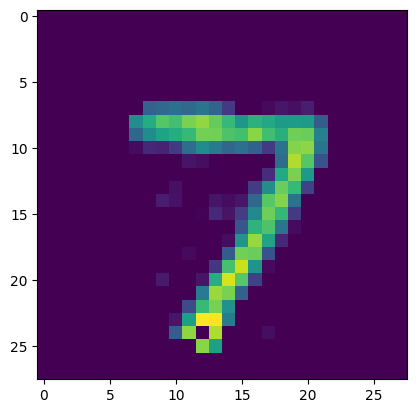

In [13]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

# run training loop
model.fit(train_data, train_data, epochs=n_epochs)

# evaluate performance on test set
model.evaluate(test_data, test_data)

# display example output
output = model.predict(test_data[[0]])
plt.figure()
plt.imshow(output[0].reshape((28, 28)))
plt.show()

Before running the same training in NengoDL, we'll change the Nengo model parameters to
more closely match the TensorFlow network (we omitted these details in the original
presentation to keep things simple).

In [14]:
# set initial neuron gains to 1 and biases to 0
for ens in auto_net.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net.all_connections:
    conn.synapse = None

We also need to modify the data slightly.  As mentioned above, NengoDL simulations are
essentially temporal, so data is described over time (indicating what the inputs/targets
should be on each simulation timestep).  So instead of the data having shape
`(batch_size, n)`, it will have shape `(batch_size, n_steps, n)`.  In this case we'll
just be training for a single timestep, but we still need to add that extra axis with
length 1.

In [15]:
train_data = train_data[:, None, :]
test_data = test_data[:, None, :]

Now we can run the NengoDL equivalent of the above TensorFlow training (note: the
results will not match exactly due to different random initializations):

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (66%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/2


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

   1/1200 [..............................] - ETA: 21:00 - loss: 7350.3555 - probe_loss: 7350.3555

  14/1200 [..............................] - ETA: 4s - loss: 5020.9380 - probe_loss: 5020.9380   

  27/1200 [..............................] - ETA: 4s - loss: 4375.4893 - probe_loss: 4375.4893

  40/1200 [>.............................] - ETA: 4s - loss: 4007.9683 - probe_loss: 4007.9683

  53/1200 [>.............................] - ETA: 4s - loss: 3721.4275 - probe_loss: 3721.4275

  66/1200 [>.............................] - ETA: 4s - loss: 3512.9814 - probe_loss: 3512.9814

  79/1200 [>.............................] - ETA: 4s - loss: 3332.1064 - probe_loss: 3332.1064

  93/1200 [=>............................] - ETA: 4s - loss: 3176.9817 - probe_loss: 3176.9817

 107/1200 [=>............................] - ETA: 4s - loss: 3048.3208 - probe_loss: 3048.3208

 120/1200 [==>...........................] - ETA: 4s - loss: 2947.3257 - probe_loss: 2947.3257

 134/1200 [==>...........................] - ETA: 4s - loss: 2854.3232 - probe_loss: 2854.3232

 148/1200 [==>...........................] - ETA: 4s - loss: 2771.2048 - probe_loss: 2771.2048

 162/1200 [===>..........................] - ETA: 4s - loss: 2695.2776 - probe_loss: 2695.2776

 176/1200 [===>..........................] - ETA: 3s - loss: 2626.9258 - probe_loss: 2626.9258

 190/1200 [===>..........................] - ETA: 3s - loss: 2569.8618 - probe_loss: 2569.8618

 203/1200 [====>.........................] - ETA: 3s - loss: 2518.7078 - probe_loss: 2518.7078

 216/1200 [====>.........................] - ETA: 3s - loss: 2474.7114 - probe_loss: 2474.7114

 229/1200 [====>.........................] - ETA: 3s - loss: 2431.3274 - probe_loss: 2431.3274

 243/1200 [=====>........................] - ETA: 3s - loss: 2389.3567 - probe_loss: 2389.3567

 257/1200 [=====>........................] - ETA: 3s - loss: 2349.5374 - probe_loss: 2349.5374

 271/1200 [=====>........................] - ETA: 3s - loss: 2311.5823 - probe_loss: 2311.5823

 284/1200 [======>.......................] - ETA: 3s - loss: 2279.2388 - probe_loss: 2279.2388

 298/1200 [======>.......................] - ETA: 3s - loss: 2246.3279 - probe_loss: 2246.3279

 312/1200 [======>.......................] - ETA: 3s - loss: 2216.2637 - probe_loss: 2216.2637

 325/1200 [=======>......................] - ETA: 3s - loss: 2188.7754 - probe_loss: 2188.7754

 339/1200 [=======>......................] - ETA: 3s - loss: 2162.3975 - probe_loss: 2162.3975

 353/1200 [=======>......................] - ETA: 3s - loss: 2137.4783 - probe_loss: 2137.4783

 367/1200 [========>.....................] - ETA: 3s - loss: 2114.0938 - probe_loss: 2114.0938

 381/1200 [========>.....................] - ETA: 3s - loss: 2091.8767 - probe_loss: 2091.8767

 395/1200 [========>.....................] - ETA: 3s - loss: 2069.4910 - probe_loss: 2069.4910

 409/1200 [=========>....................] - ETA: 3s - loss: 2049.0481 - probe_loss: 2049.0481

 423/1200 [=========>....................] - ETA: 2s - loss: 2031.1027 - probe_loss: 2031.1027

 437/1200 [=========>....................] - ETA: 2s - loss: 2011.2212 - probe_loss: 2011.2212

 450/1200 [==========>...................] - ETA: 2s - loss: 1994.9852 - probe_loss: 1994.9852

 463/1200 [==========>...................] - ETA: 2s - loss: 1978.8157 - probe_loss: 1978.8157

 476/1200 [==========>...................] - ETA: 2s - loss: 1964.5021 - probe_loss: 1964.5021

 490/1200 [===========>..................] - ETA: 2s - loss: 1949.7126 - probe_loss: 1949.7126

 504/1200 [===========>..................] - ETA: 2s - loss: 1934.4493 - probe_loss: 1934.4493

 518/1200 [===========>..................] - ETA: 2s - loss: 1919.8690 - probe_loss: 1919.8690

 532/1200 [============>.................] - ETA: 2s - loss: 1905.7097 - probe_loss: 1905.7097

 545/1200 [============>.................] - ETA: 2s - loss: 1892.0928 - probe_loss: 1892.0928

 559/1200 [============>.................] - ETA: 2s - loss: 1878.9984 - probe_loss: 1878.9984

 573/1200 [=============>................] - ETA: 2s - loss: 1865.1945 - probe_loss: 1865.1945

 587/1200 [=============>................] - ETA: 2s - loss: 1852.9958 - probe_loss: 1852.9958

 601/1200 [==============>...............] - ETA: 2s - loss: 1840.7056 - probe_loss: 1840.7056

 614/1200 [==============>...............] - ETA: 2s - loss: 1830.7268 - probe_loss: 1830.7268

 627/1200 [==============>...............] - ETA: 2s - loss: 1821.2141 - probe_loss: 1821.2141

 641/1200 [===============>..............] - ETA: 2s - loss: 1810.9208 - probe_loss: 1810.9208

 655/1200 [===============>..............] - ETA: 2s - loss: 1799.8363 - probe_loss: 1799.8363

 669/1200 [===============>..............] - ETA: 2s - loss: 1789.3197 - probe_loss: 1789.3197

 683/1200 [================>.............] - ETA: 1s - loss: 1780.3577 - probe_loss: 1780.3577

 697/1200 [================>.............] - ETA: 1s - loss: 1770.7001 - probe_loss: 1770.7001

 710/1200 [================>.............] - ETA: 1s - loss: 1762.0770 - probe_loss: 1762.0770

 723/1200 [=================>............] - ETA: 1s - loss: 1754.0107 - probe_loss: 1754.0107

 737/1200 [=================>............] - ETA: 1s - loss: 1745.2109 - probe_loss: 1745.2109

 751/1200 [=================>............] - ETA: 1s - loss: 1736.9707 - probe_loss: 1736.9707

 765/1200 [==================>...........] - ETA: 1s - loss: 1728.9402 - probe_loss: 1728.9402

 779/1200 [==================>...........] - ETA: 1s - loss: 1721.0388 - probe_loss: 1721.0388

 793/1200 [==================>...........] - ETA: 1s - loss: 1712.7114 - probe_loss: 1712.7114

 807/1200 [===================>..........] - ETA: 1s - loss: 1705.1511 - probe_loss: 1705.1511

 821/1200 [===================>..........] - ETA: 1s - loss: 1698.1757 - probe_loss: 1698.1757

 835/1200 [===================>..........] - ETA: 1s - loss: 1690.4841 - probe_loss: 1690.4841

 848/1200 [====================>.........] - ETA: 1s - loss: 1683.8287 - probe_loss: 1683.8287

 862/1200 [====================>.........] - ETA: 1s - loss: 1677.2050 - probe_loss: 1677.2050

 876/1200 [====================>.........] - ETA: 1s - loss: 1669.7894 - probe_loss: 1669.7894

 890/1200 [=====================>........] - ETA: 1s - loss: 1662.4844 - probe_loss: 1662.4844

 904/1200 [=====================>........] - ETA: 1s - loss: 1656.6581 - probe_loss: 1656.6581

 918/1200 [=====================>........] - ETA: 1s - loss: 1649.9712 - probe_loss: 1649.9712

 932/1200 [======================>.......] - ETA: 1s - loss: 1643.8766 - probe_loss: 1643.8766

 945/1200 [======================>.......] - ETA: 0s - loss: 1638.4816 - probe_loss: 1638.4816

 959/1200 [======================>.......] - ETA: 0s - loss: 1632.4093 - probe_loss: 1632.4093

 969/1200 [=======================>......] - ETA: 0s - loss: 1628.1592 - probe_loss: 1628.1592

 983/1200 [=======================>......] - ETA: 0s - loss: 1622.6848 - probe_loss: 1622.6848

 996/1200 [=======================>......] - ETA: 0s - loss: 1617.6575 - probe_loss: 1617.6575

1009/1200 [========================>.....] - ETA: 0s - loss: 1612.0585 - probe_loss: 1612.0585

1023/1200 [========================>.....] - ETA: 0s - loss: 1606.8850 - probe_loss: 1606.8850

1036/1200 [========================>.....] - ETA: 0s - loss: 1602.1078 - probe_loss: 1602.1078

1050/1200 [=========================>....] - ETA: 0s - loss: 1596.9379 - probe_loss: 1596.9379

1064/1200 [=========================>....] - ETA: 0s - loss: 1591.9631 - probe_loss: 1591.9631

1076/1200 [=========================>....] - ETA: 0s - loss: 1588.3353 - probe_loss: 1588.3353

1090/1200 [==========================>...] - ETA: 0s - loss: 1583.6382 - probe_loss: 1583.6382

1104/1200 [==========================>...] - ETA: 0s - loss: 1579.1990 - probe_loss: 1579.1990

1118/1200 [==========================>...] - ETA: 0s - loss: 1574.4342 - probe_loss: 1574.4342

1132/1200 [===========================>..] - ETA: 0s - loss: 1569.9955 - probe_loss: 1569.9955

1146/1200 [===========================>..] - ETA: 0s - loss: 1565.8575 - probe_loss: 1565.8575

1160/1200 [============================>.] - ETA: 0s - loss: 1561.8843 - probe_loss: 1561.8843

1174/1200 [============================>.] - ETA: 0s - loss: 1557.6857 - probe_loss: 1557.6857

1188/1200 [============================>.] - ETA: 0s - loss: 1553.9478 - probe_loss: 1553.9478

1200/1200 [==============================] - 6s 4ms/step - loss: 1550.3524 - probe_loss: 1550.3524


Epoch 2/2


   1/1200 [..............................] - ETA: 5s - loss: 1318.4572 - probe_loss: 1318.4572

  15/1200 [..............................] - ETA: 4s - loss: 1229.2289 - probe_loss: 1229.2289

  28/1200 [..............................] - ETA: 4s - loss: 1206.9962 - probe_loss: 1206.9962

  42/1200 [>.............................] - ETA: 4s - loss: 1200.9491 - probe_loss: 1200.9491

  56/1200 [>.............................] - ETA: 4s - loss: 1196.5201 - probe_loss: 1196.5201

  69/1200 [>.............................] - ETA: 4s - loss: 1189.6979 - probe_loss: 1189.6979

  82/1200 [=>............................] - ETA: 4s - loss: 1192.1323 - probe_loss: 1192.1323

  95/1200 [=>............................] - ETA: 4s - loss: 1193.5077 - probe_loss: 1193.5077

 108/1200 [=>............................] - ETA: 4s - loss: 1200.1172 - probe_loss: 1200.1172

 121/1200 [==>...........................] - ETA: 4s - loss: 1203.5413 - probe_loss: 1203.5413

 135/1200 [==>...........................] - ETA: 4s - loss: 1195.5344 - probe_loss: 1195.5344

 149/1200 [==>...........................] - ETA: 4s - loss: 1200.4222 - probe_loss: 1200.4222

 162/1200 [===>..........................] - ETA: 4s - loss: 1194.9956 - probe_loss: 1194.9956

 172/1200 [===>..........................] - ETA: 4s - loss: 1194.4568 - probe_loss: 1194.4568

 185/1200 [===>..........................] - ETA: 4s - loss: 1195.2452 - probe_loss: 1195.2452

 199/1200 [===>..........................] - ETA: 3s - loss: 1189.7792 - probe_loss: 1189.7792

 213/1200 [====>.........................] - ETA: 3s - loss: 1188.1432 - probe_loss: 1188.1432

 226/1200 [====>.........................] - ETA: 3s - loss: 1184.2095 - probe_loss: 1184.2095

 240/1200 [=====>........................] - ETA: 3s - loss: 1184.1874 - probe_loss: 1184.1874

 254/1200 [=====>........................] - ETA: 3s - loss: 1183.0707 - probe_loss: 1183.0707

 268/1200 [=====>........................] - ETA: 3s - loss: 1184.6979 - probe_loss: 1184.6979

 282/1200 [======>.......................] - ETA: 3s - loss: 1183.4401 - probe_loss: 1183.4401

 295/1200 [======>.......................] - ETA: 3s - loss: 1182.2163 - probe_loss: 1182.2163

 309/1200 [======>.......................] - ETA: 3s - loss: 1180.9377 - probe_loss: 1180.9377

 323/1200 [=======>......................] - ETA: 3s - loss: 1178.0312 - probe_loss: 1178.0312

 337/1200 [=======>......................] - ETA: 3s - loss: 1176.0339 - probe_loss: 1176.0339

 348/1200 [=======>......................] - ETA: 3s - loss: 1173.8273 - probe_loss: 1173.8273

 359/1200 [=======>......................] - ETA: 3s - loss: 1174.4100 - probe_loss: 1174.4100

 372/1200 [========>.....................] - ETA: 3s - loss: 1172.6760 - probe_loss: 1172.6760

 385/1200 [========>.....................] - ETA: 3s - loss: 1172.6980 - probe_loss: 1172.6980

 399/1200 [========>.....................] - ETA: 3s - loss: 1172.3362 - probe_loss: 1172.3362

 413/1200 [=========>....................] - ETA: 3s - loss: 1171.5305 - probe_loss: 1171.5305

 426/1200 [=========>....................] - ETA: 3s - loss: 1169.4523 - probe_loss: 1169.4523

 440/1200 [==========>...................] - ETA: 2s - loss: 1167.4426 - probe_loss: 1167.4426

 454/1200 [==========>...................] - ETA: 2s - loss: 1166.1328 - probe_loss: 1166.1328

 468/1200 [==========>...................] - ETA: 2s - loss: 1165.1871 - probe_loss: 1165.1871

 482/1200 [===========>..................] - ETA: 2s - loss: 1164.6107 - probe_loss: 1164.6107

 496/1200 [===========>..................] - ETA: 2s - loss: 1163.7324 - probe_loss: 1163.7324

 510/1200 [===========>..................] - ETA: 2s - loss: 1162.9064 - probe_loss: 1162.9064

 524/1200 [============>.................] - ETA: 2s - loss: 1162.4929 - probe_loss: 1162.4929

 538/1200 [============>.................] - ETA: 2s - loss: 1161.6038 - probe_loss: 1161.6038

 552/1200 [============>.................] - ETA: 2s - loss: 1160.8726 - probe_loss: 1160.8726

 566/1200 [=============>................] - ETA: 2s - loss: 1160.4310 - probe_loss: 1160.4310

 579/1200 [=============>................] - ETA: 2s - loss: 1160.2794 - probe_loss: 1160.2794

 593/1200 [=============>................] - ETA: 2s - loss: 1159.5642 - probe_loss: 1159.5642

 606/1200 [==============>...............] - ETA: 2s - loss: 1157.9429 - probe_loss: 1157.9429

 620/1200 [==============>...............] - ETA: 2s - loss: 1157.0715 - probe_loss: 1157.0715

 634/1200 [==============>...............] - ETA: 2s - loss: 1156.8770 - probe_loss: 1156.8770

 647/1200 [===============>..............] - ETA: 2s - loss: 1155.8646 - probe_loss: 1155.8646

 661/1200 [===============>..............] - ETA: 2s - loss: 1154.7643 - probe_loss: 1154.7643

 675/1200 [===============>..............] - ETA: 2s - loss: 1153.5411 - probe_loss: 1153.5411

 687/1200 [================>.............] - ETA: 1s - loss: 1152.2294 - probe_loss: 1152.2294

 701/1200 [================>.............] - ETA: 1s - loss: 1152.0573 - probe_loss: 1152.0573

 715/1200 [================>.............] - ETA: 1s - loss: 1151.0049 - probe_loss: 1151.0049

 729/1200 [=================>............] - ETA: 1s - loss: 1150.3856 - probe_loss: 1150.3856

 743/1200 [=================>............] - ETA: 1s - loss: 1150.0845 - probe_loss: 1150.0845

 756/1200 [=================>............] - ETA: 1s - loss: 1148.9742 - probe_loss: 1148.9742

 770/1200 [==================>...........] - ETA: 1s - loss: 1148.7673 - probe_loss: 1148.7673

 784/1200 [==================>...........] - ETA: 1s - loss: 1148.2188 - probe_loss: 1148.2188

 798/1200 [==================>...........] - ETA: 1s - loss: 1148.0303 - probe_loss: 1148.0303

 812/1200 [===================>..........] - ETA: 1s - loss: 1147.7385 - probe_loss: 1147.7385

 826/1200 [===================>..........] - ETA: 1s - loss: 1147.3605 - probe_loss: 1147.3605

 840/1200 [====================>.........] - ETA: 1s - loss: 1147.1288 - probe_loss: 1147.1288

 854/1200 [====================>.........] - ETA: 1s - loss: 1146.3743 - probe_loss: 1146.3743

 867/1200 [====================>.........] - ETA: 1s - loss: 1145.9735 - probe_loss: 1145.9735

 881/1200 [=====================>........] - ETA: 1s - loss: 1144.7865 - probe_loss: 1144.7865

 895/1200 [=====================>........] - ETA: 1s - loss: 1144.1454 - probe_loss: 1144.1454

 909/1200 [=====================>........] - ETA: 1s - loss: 1143.4951 - probe_loss: 1143.4951

 923/1200 [======================>.......] - ETA: 1s - loss: 1142.9785 - probe_loss: 1142.9785

 937/1200 [======================>.......] - ETA: 1s - loss: 1141.9709 - probe_loss: 1141.9709

 951/1200 [======================>.......] - ETA: 0s - loss: 1141.9230 - probe_loss: 1141.9230

 965/1200 [=======================>......] - ETA: 0s - loss: 1141.7109 - probe_loss: 1141.7109

 977/1200 [=======================>......] - ETA: 0s - loss: 1141.0078 - probe_loss: 1141.0078

 990/1200 [=======================>......] - ETA: 0s - loss: 1140.5486 - probe_loss: 1140.5486

1003/1200 [========================>.....] - ETA: 0s - loss: 1140.3352 - probe_loss: 1140.3352

1017/1200 [========================>.....] - ETA: 0s - loss: 1139.6700 - probe_loss: 1139.6700

1031/1200 [========================>.....] - ETA: 0s - loss: 1138.8043 - probe_loss: 1138.8043

1045/1200 [=========================>....] - ETA: 0s - loss: 1138.3358 - probe_loss: 1138.3358

1059/1200 [=========================>....] - ETA: 0s - loss: 1137.7841 - probe_loss: 1137.7841

1068/1200 [=========================>....] - ETA: 0s - loss: 1137.5885 - probe_loss: 1137.5885

1082/1200 [==========================>...] - ETA: 0s - loss: 1136.7164 - probe_loss: 1136.7164

1094/1200 [==========================>...] - ETA: 0s - loss: 1136.5471 - probe_loss: 1136.5471

1107/1200 [==========================>...] - ETA: 0s - loss: 1136.0676 - probe_loss: 1136.0676

1121/1200 [===========================>..] - ETA: 0s - loss: 1136.0874 - probe_loss: 1136.0874

1135/1200 [===========================>..] - ETA: 0s - loss: 1135.7996 - probe_loss: 1135.7996

1149/1200 [===========================>..] - ETA: 0s - loss: 1135.2336 - probe_loss: 1135.2336

1163/1200 [============================>.] - ETA: 0s - loss: 1134.7909 - probe_loss: 1134.7909

1177/1200 [============================>.] - ETA: 0s - loss: 1134.5364 - probe_loss: 1134.5364

1191/1200 [============================>.] - ETA: 0s - loss: 1134.5295 - probe_loss: 1134.5295

1200/1200 [==============================] - 5s 4ms/step - loss: 1134.0219 - probe_loss: 1134.0219


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (66%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

  1/200 [..............................] - ETA: 47s - loss: 925.8317 - probe_loss: 925.8317

 18/200 [=>............................] - ETA: 0s - loss: 1007.9356 - probe_loss: 1007.9356

 37/200 [====>.........................] - ETA: 0s - loss: 1001.9221 - probe_loss: 1001.9221

 55/200 [=======>......................] - ETA: 0s - loss: 1002.3528 - probe_loss: 1002.3528

 73/200 [=========>....................] - ETA: 0s - loss: 1002.9501 - probe_loss: 1002.9501

 92/200 [============>.................] - ETA: 0s - loss: 1009.0953 - probe_loss: 1009.0953

111/200 [===============>..............] - ETA: 0s - loss: 1010.9463 - probe_loss: 1010.9463

129/200 [==================>...........] - ETA: 0s - loss: 1035.6052 - probe_loss: 1035.6052

146/200 [====================>.........] - ETA: 0s - loss: 1036.1194 - probe_loss: 1036.1194

165/200 [=======================>......] - ETA: 0s - loss: 1055.3485 - probe_loss: 1055.3485

183/200 [==========================>...] - ETA: 0s - loss: 1066.8820 - probe_loss: 1066.8820

200/200 [==============================] - 1s 3ms/step - loss: 1066.9366 - probe_loss: 1066.9366


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 220ms/step


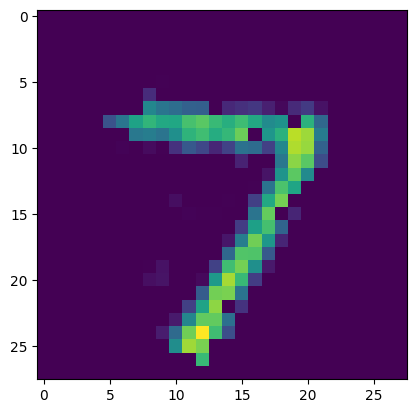

In [16]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    sim.evaluate(test_data, test_data)

    # display example output
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_c][0].reshape((28, 28)))
    plt.show()

More details on using `sim.fit` can be found in [the user
guide](https://www.nengo.ai/nengo-dl/simulator.html).

## NEF parameter optimization

NengoDL also provides access to a different optimization method, the Neural Engineering
Framework (NEF).  This uses linear least-squares optimization to solve for optimal
connection weights analytically, rather than using an iterative gradient-descent based
algorithm.  The advantage of the NEF is that it is very fast and general (for example,
it does not require the network to be differentiable).  The disadvantage is that it
optimizes each set of connection weights individually (i.e., it cannot jointly optimize
across multiple layers).

The NEF optimization is accessed by setting the `function` argument on a
`nengo.Connection`.  This specifies the function that we would like those connection
weights to approximate.  In addition, in previous examples you may have noticed that we
were forming Connections using `ensemble.neurons` (rather than `ensemble`).  Using
`ensemble.neurons` specifies that we want to form a direct connection between ensemble
neurons, without applying the NEF optimization.  So when we want to use the `function`
argument, the `Connection` source object should be an `ensemble`, not
`ensemble.neurons`.  For example, we could use the NEF to create a network to
approximate the function $sin(x^2)$:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (22%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (22%)             | ETA: 0:00:00

| #                           Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

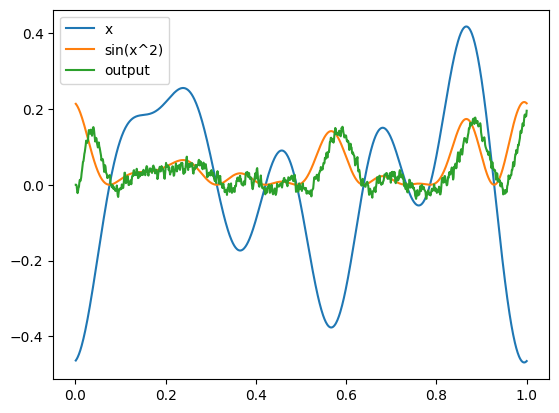

In [17]:
with nengo.Network(seed=0) as net:
    # input node outputting a random signal for x
    inpt = nengo.Node(nengo.processes.WhiteSignal(1, 5, rms=0.3))

    # first ensemble, will compute x^2
    ens0 = nengo.Ensemble(50, 1)

    # second ensemble, will compute sin(x^2)
    ens1 = nengo.Ensemble(50, 1)

    # output node
    outpt = nengo.Node(size_in=1)

    # connect input to first ensemble
    nengo.Connection(inpt, ens0)

    # connect first to second ensemble, solve for weights
    # to approximate the square function
    nengo.Connection(ens0, ens1, function=np.square)

    # connect second ensemble to output, solve for weights
    # to approximate the sin function
    nengo.Connection(ens1, outpt, function=np.sin)

    # add a probe on the input and output
    inpt_p = nengo.Probe(inpt)
    outpt_p = nengo.Probe(outpt, synapse=0.005)

with nengo_dl.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p] ** 2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend()
plt.show()

The NEF optimization can be used in combination with the deep learning optimization
methods.  For example, we could optimize some parameters with the NEF and others with
`sim.fit` (see [this example](https://www.nengo.ai/nengo-dl/examples/from-nengo.html)).
Or we could initialize each set of connection weights individually with the NEF, and
then further refine them with end-to-end training via `sim.fit`.  As always, the overall
theme is that NengoDL allows us to use whichever method is most appropriate for a
particular goal.

See [this example](https://www.nengo.ai/nengo/examples/advanced/nef_summary.html) for a
deeper introduction to the principles of the NEF.

## Running on neuromorphic hardware

Neuromorphic hardware is specialized compute hardware designed to simulate neuromorphic
networks quickly/efficiently.  However, often it is difficult to program this custom
hardware, and it requires writing custom code for each neuromorphic platform.  One of
the primary design goals of Nengo is to alleviate these challenges, by providing a
single API that can be used to build networks across many different neuromorphic
platforms.

The idea is that the front-end network construction code is the same (`Networks`,
`Nodes`, `Ensembles`, `Connections`, and `Probes`), and then each platform has its own
`Simulator` class (the back-end) that compiles and executes that network definition for
some compute platform.  This provides a consistent interface so that we only need to
write code once and can then run that network on novel hardware platforms with no
additional effort.  For example, we could take the network from above and simulate it on
different hardware platforms:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

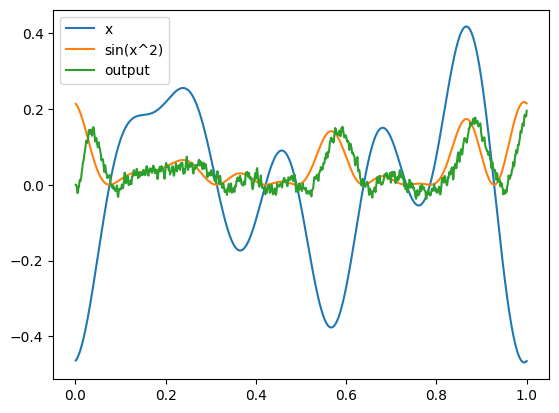

In [18]:
# run on a standard CPU
with nengo.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)

# run on Loihi neuromorphic hardware
# (requires https://www.nengo.ai/nengo-loihi/)
# with nengo_loihi.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

# run on SpiNNaker neuromorphic hardware
# (requires https://github.com/project-rig/nengo_spinnaker)
# with nengo_spinnaker.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

# run on any OpenCL-compatible hardware
# (requires https://github.com/nengo-labs/nengo-ocl)
# with nengo_ocl.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p] ** 2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend()
plt.show()

We have commented out the different backends above because they require extra
installation steps, but if you are running this example yourself you can install any of
those backends (or more) and uncomment that code to see the same network running on that
new hardware platform.  Note that we can think of NengoDL as a TensorFlow back-end
(among other things); it takes a standard Nengo network, and simulates it using
TensorFlow.

We can take advantage of this cross-platform compatibility to effectively incorporate
NengoDL's deep learning functionality into any other Nengo back-end.  We build our
Network, optimize it in NengoDL, save the optimized model parameters back into the
Network definition, and then simulate that optimized Network in a different back-end.
See [this example in
nengo-loihi](https://www.nengo.ai/nengo-loihi/examples/mnist_convnet.html), where a
spiking network is optimized in NengoDL and then deployed on Loihi.

## Conclusion

In this tutorial we have demonstrated how to translate TensorFlow concepts into NengoDL,
including network construction, execution, and optimization.  We have also discussed how
to use TensorNodes to combine TensorFlow and Nengo code, and introduced some of the
unique features of Nengo (such as NEF optimization and neuromorphic cross-platform
execution).  However, there is much more functionality in NengoDL than we are able to
introduce here; check out the [user
guide](https://www.nengo.ai/nengo-dl/user-guide.html) or [other
examples](https://www.nengo.ai/nengo-dl/examples.html) for more information.  If you
would like more information on how NengoDL is implemented under the hood using
TensorFlow, check out the [white paper](https://arxiv.org/abs/1805.11144).